In [2]:
from pathlib import Path
import numpy as np
from scipy.io import loadmat

from parameter import Parameter

In [3]:
path_kpg_folder = Path.cwd().resolve().parents[0] / "data" / "input" / "KPG193_ver1_2"

In [4]:
raw = loadmat(path_kpg_folder / "network" / "mat" / "KPG193_ver1_2.mat")["mpc"][0, 0]

if raw["gencost"][:, 2].sum():
    raise NotImplementedError("nonzero shutdown for some unit")

if (raw["gencost"][:, 3] > 3).sum():
    raise NotImplementedError("number of cost coefficients for some unit exceeding 3")

if (raw["gencost"][:, 1] != raw["genthermal"][:, 9]).sum():
    raise ValueError("\"startup\" in mpc.gencost does not match \"startup1\" in mpc.genthermal")

In [5]:
# KPG193_ver1_2 specific
fx_rate = 1000
thermal_unit_type = np.array([
    1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
    2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 
    0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2
])

thermal_cost_const, thermal_cost_lin, thermal_cost_quad = (raw["gencost"][:, [-1, -2, -3]] * fx_rate).transpose()

thermal_p_max, thermal_p_min = raw["gen"][:, [8, 9]].transpose()

(
    thermal_ramp_up,
    thermal_ramp_down,
    thermal_startup_ramp,
    thermal_shutdown_ramp,
    thermal_min_up,
    thermal_min_down,
) = raw["genthermal"][:, [5, 6, 7, 8, 1, 2]].transpose()

thermal_cost_startup_step = []
for idx, (cost_startup_pseudo_i, startup_delay_i) in enumerate(zip(
    (raw["genthermal"][:, -6:-3] * fx_rate).tolist(),   # startupi
    raw["genthermal"][:, -3:].astype(int)               # "startupdelayi"
)):
    thermal_cost_startup_step.append(
            [cost_startup_pseudo_i[0]] * startup_delay_i[0]
            + [cost_startup_pseudo_i[1]] * (startup_delay_i[1] - startup_delay_i[0])
            + [cost_startup_pseudo_i[2]] * (startup_delay_i[2] - startup_delay_i[1])
        )


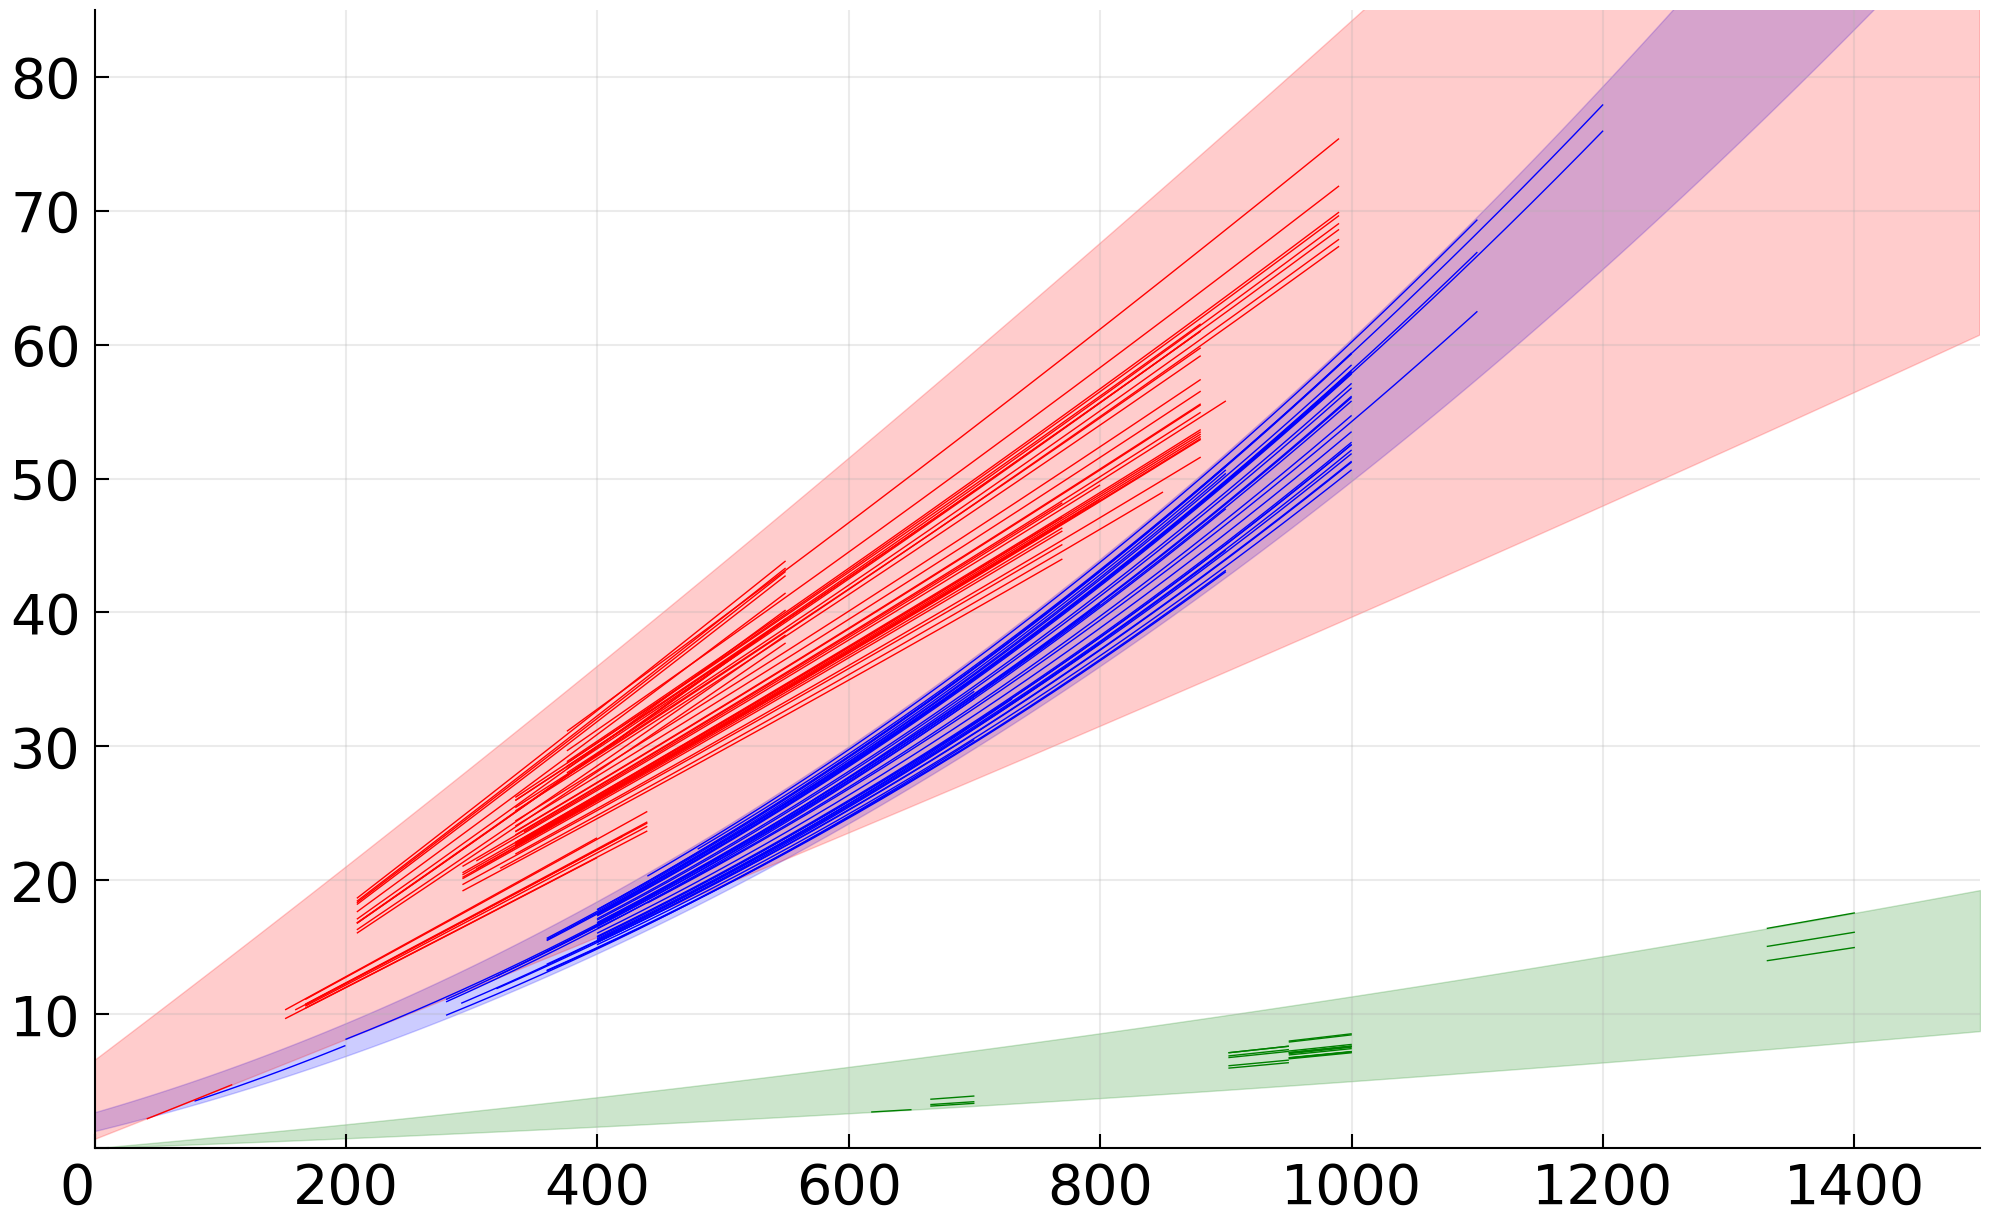

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def quad_cost(ps, c_quad, c_lin, c_const):
    return (c_quad * ps**2 + c_lin * ps + c_const) / 1e6 # 1M KRW

ps_grid = np.linspace(0, 1500, 1500)
utype_colors = {0: "green", 1: "blue", 2: "red"}

fig, ax = plt.subplots(figsize=(20, 20 / 1.618))

for (c_quad, c_lin, c_const, pmin, pmax, utype) in zip(
    thermal_cost_quad,
    thermal_cost_lin,
    thermal_cost_const,
    thermal_p_min,
    thermal_p_max,
    thermal_unit_type,
):
    ps_i = ps_grid[(pmin <= ps_grid) & (ps_grid <= pmax)]
    ax.plot(ps_i, quad_cost(ps_i, c_quad, c_lin, c_const), linewidth=1, color=utype_colors[utype])

for utype, color in utype_colors.items():
    mask = (thermal_unit_type == utype)
    y_max = quad_cost(ps_grid, thermal_cost_quad[mask].max(), thermal_cost_lin[mask].max(), thermal_cost_const[mask].max())
    y_min = quad_cost(ps_grid, thermal_cost_quad[mask].min(), thermal_cost_lin[mask].min(), thermal_cost_const[mask].min())
    ax.fill_between(ps_grid, y_min, y_max, color=color, alpha=0.2)

ax.grid(linewidth=1.5, alpha=0.25, zorder=0)
for side in ["top", "right"]:
    ax.spines[side].set_visible(False)
for side in ["bottom", "left"]:
    ax.spines[side].set_linewidth(1.5)

ax.tick_params(
    axis="both", which="major", direction="in",
    width=1.5, length=10, labelsize=40, pad=10
)

ax.get_xticklabels(minor=False)[0].set_horizontalalignment("right")
ax.get_yticklabels(minor=False)[0].set_visible(False)

ax.set_ylim(0, 85)
ax.set_xlim(0, 1500)

plt.tight_layout()
plt.show()
